# Graph Learning
## Lab 4: Hierarchical Clustering

In this lab, you will learn to analyse the hierarchical structure of a graph. 

## Import

In [441]:
from IPython.display import SVG

In [442]:
import numpy as np
from scipy import sparse

In [443]:
from sknetwork.data import load_netset, karate_club
from sknetwork.hierarchy import LouvainIteration, Paris, cut_straight
from sknetwork.ranking import PageRank
from sknetwork.visualization import visualize_graph, visualize_dendrogram

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paristech.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph)

In [444]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club), a small graph with ground-truth clusters.

In [445]:
dataset = karate_club(True)

In [446]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

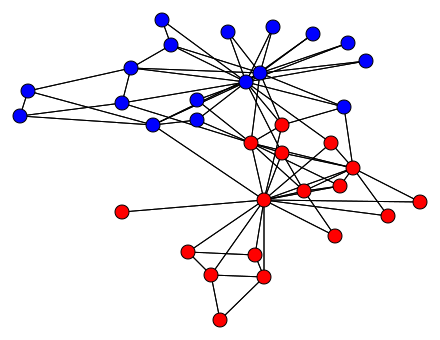

In [447]:
image = visualize_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Cluster the graph by the hierarchical Louvain algorithm (divisive algorithm, top-down).
* Display the dendrogram.
* How many clusters are there at depth 1?
* Display the graph with the corresponding clustering.
* How many clusters are there at depth 2?

In [448]:
louvain = LouvainIteration()

In [449]:
dendrogram = louvain.fit_predict(adjacency)

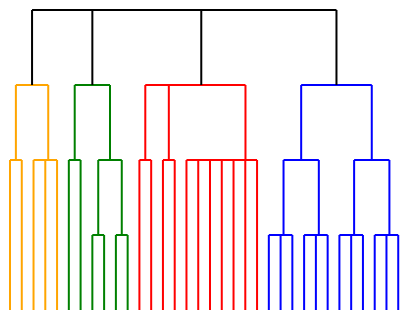

In [450]:
image = visualize_dendrogram(dendrogram)
SVG(image)

In [451]:
# find a clustering with n_clusters (at least n_clusters, if there is no cut with n_clusters)
labels = cut_straight(dendrogram, n_clusters=2)

In [452]:
nb_clusters_depth1 = len(set(labels))
print(f'Number of clusters at depth 1: {nb_clusters_depth1}')

Number of clusters at depth 1: 4


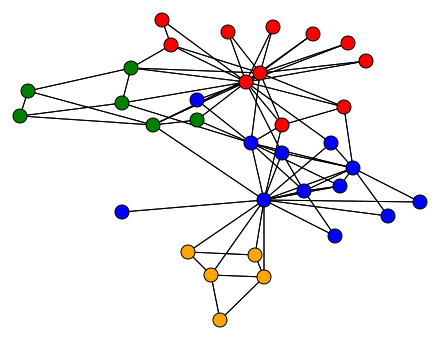

In [453]:
image = visualize_graph(adjacency, position, labels=labels)
SVG(image)

In [454]:
labels_depth2 = cut_straight(dendrogram, n_clusters=nb_clusters_depth1 + 1)
nb_clusters_depth2 = len(set(labels_depth2))
print(f'Number of clusters at depth 2: {nb_clusters_depth2}')

Number of clusters at depth 2: 9


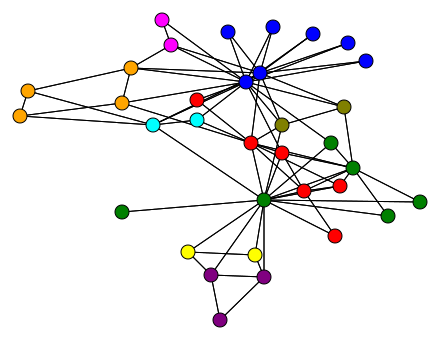

In [455]:
image = visualize_graph(adjacency, position, labels=labels_depth2)
SVG(image)

## To do

* Cluster the graph by the Paris algorithm.
* Display the dendrogram.
* Display the graph with the top-2 clusters. Compare this clustering to the ground-truth labels.
* Display the graph with the top-4 clusters. Compare this clustering with that given by Louvain (depth 1). 
* Display the corresponding aggregate dendrogram (check the parameters of the function ``cut_straight``).

In [456]:
paris = Paris()

In [457]:
dendrogram = paris.fit_predict(adjacency)

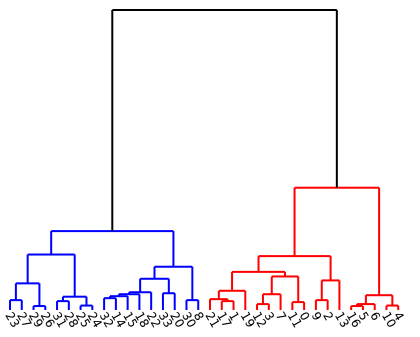

In [458]:
image = visualize_dendrogram(dendrogram, names=np.arange(34))
SVG(image)

Graph with top 2 clusters:


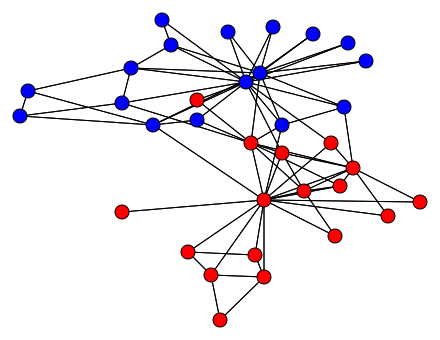

Graph with ground truth labels:


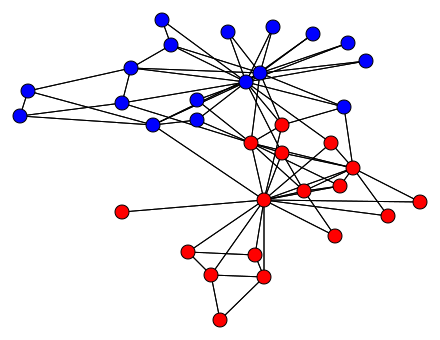

In [459]:
labels_top2 = cut_straight(dendrogram, n_clusters=2)
image = visualize_graph(adjacency, position, labels=labels_top2)
print("Graph with top 2 clusters:")
display(SVG(image))

# Ground truth labels
image = visualize_graph(adjacency, position, labels=labels_true)
print("Graph with ground truth labels:")
display(SVG(image))

The clusters are a little bit different but they have the same amount of nodes.

Graph with top 4 clusters:


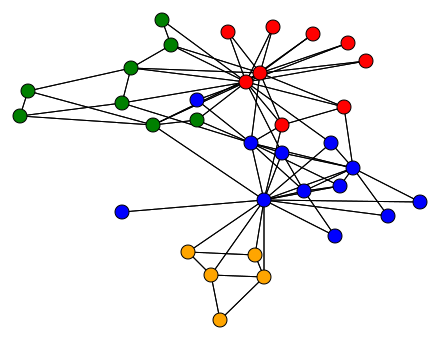

In [460]:
labels_top4 = cut_straight(dendrogram, n_clusters=4)
image = visualize_graph(adjacency, position, labels=labels_top4)
print("Graph with top 4 clusters:")
SVG(image)

We can see that the top-4 clusters clustered by the Paris algorithm and those clustered by the hierarchical Louvain algorithm with depth 1 are the same.

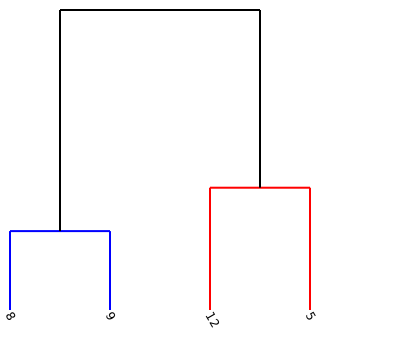

In [461]:
labels, dendrogram_aggregate = cut_straight(dendrogram, n_clusters=4, return_dendrogram=True)
_, counts = np.unique(labels, return_counts=True)

image = visualize_dendrogram(dendrogram_aggregate, names=counts)
SVG(image)

## Openflights


In [462]:
dataset = openflights

In [463]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

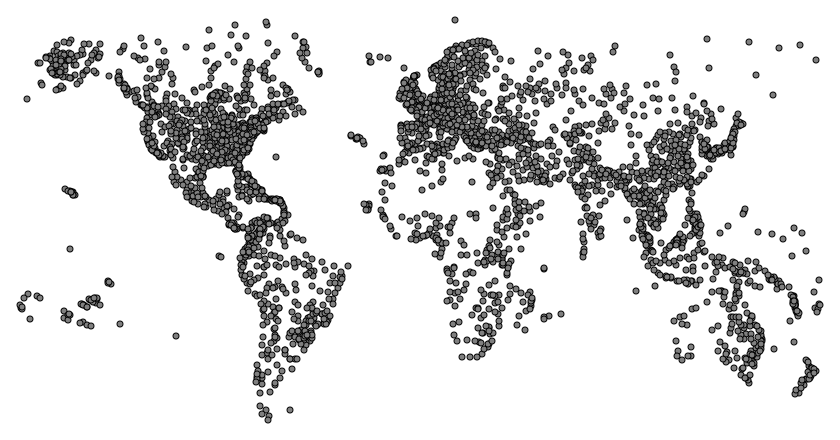

In [464]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the top-10 clusters found by Paris.<br>
Refer to the [tutorial on Louvain](https://scikit-network.readthedocs.io/en/latest/tutorials/clustering/louvain.html) to display the aggregate graph.
* Display the aggregate dendrogram formed by the top-40 clusters found by Paris, with the name of the top airport  (in traffic) of each cluster. <br>Check the parameters of the function ``visualize_dendrogram`` for better visualization.

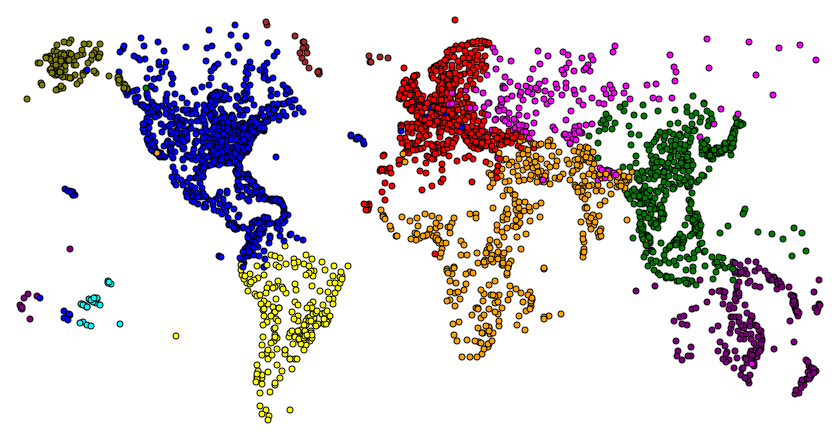

In [465]:
paris = Paris()
dendrogram = paris.fit_predict(adjacency)
labels = cut_straight(dendrogram, n_clusters=10)

image = visualize_graph(adjacency, position, labels=labels, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

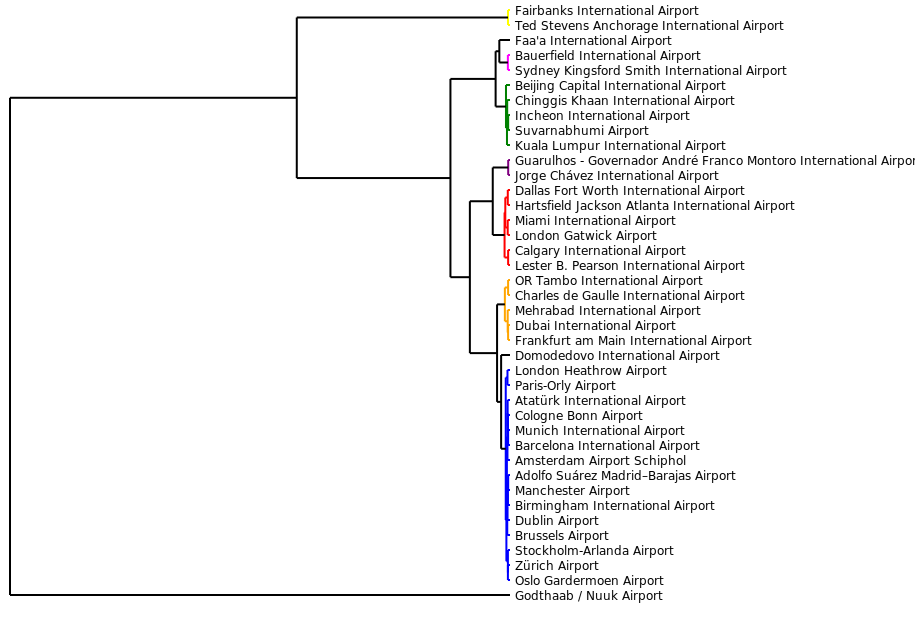

In [466]:
labels, dendrogram_aggregate = cut_straight(dendrogram, n_clusters=40, return_dendrogram=True)
labels_unique, counts = np.unique(labels, return_counts=True)
weights = adjacency.dot(np.ones(adjacency.shape[0]))
airports = []
for label in labels_unique:
    cluster = np.nonzero(labels == label)[0]
    airports.append(cluster[np.argmax(weights[cluster])])

image = visualize_dendrogram(dendrogram_aggregate, names=names[airports], rotate=True, width=500, height=600, n_clusters=10)
SVG(image)

## 2. Directed graphs

## Wikipedia Vitals

In [467]:
dataset = wikivitals

In [468]:
adjacency = dataset.adjacency
names = dataset.names

## To do

* Cluster the graph by the Paris algorithm.
* Give the size and top-5 articles (in terms of Personalized PageRank) of each of the top-40 clusters found by Paris.
* Display the aggregate dendrogram formed by the top-40 clusters, with the name of the top article of each cluster. Comment the results.


In [469]:
paris = Paris()
dendrogram = paris.fit_predict(adjacency)

labels, dendrogram_aggregate = cut_straight(dendrogram, n_clusters=40, return_dendrogram=True)
pagerank = PageRank()
labels_unique, counts = np.unique(labels, return_counts=True)

for label in labels_unique:
    cluster_indices = np.where(labels == label)[0]
    size = len(cluster_indices)

    personalization = np.zeros(adjacency.shape[0])
    personalization[cluster_indices] = 1
    scores = pagerank.fit_predict(adjacency, weights=personalization)
    top_5 = cluster_indices[np.argsort(scores[cluster_indices])[-5:][::-1]]
    top_5_names = [names[i] for i in top_5]
    print(f'Cluster {label} (size={size}): {", ".join(top_5_names)}')

Cluster 0 (size=726): The New York Times, BBC, Time (magazine), Encyclopædia Britannica, Jazz
Cluster 1 (size=674): Taxonomy (biology), Animal, Chordate, Permian, Jurassic
Cluster 2 (size=604): Plant, Flowering plant, Protein, Sugar, Gloss (optics)
Cluster 3 (size=478): World Health Organization, Medical diagnosis, Bacteria, Cancer, Immune system
Cluster 4 (size=427): Water, Pressure, Plate tectonics, Glacier, Erosion
Cluster 5 (size=329): Albert Einstein, Physics, International System of Units, Electron, Kelvin
Cluster 6 (size=318): Christianity, Catholic Church, Eastern Orthodox Church, Judaism, Augustine of Hippo
Cluster 7 (size=317): Oxygen, Hydrogen, Carbon, Nitrogen, Iron
Cluster 8 (size=293): Immanuel Kant, David Hume, Epistemology, Age of Enlightenment, Logic
Cluster 9 (size=289): Egypt, Islam, Iran, Persian language, Syria
Cluster 10 (size=287): Karl Marx, United Nations, Adam Smith, John Stuart Mill, Economics
Cluster 11 (size=286): Earth, Sun, NASA, Solar System, Star
Cluste

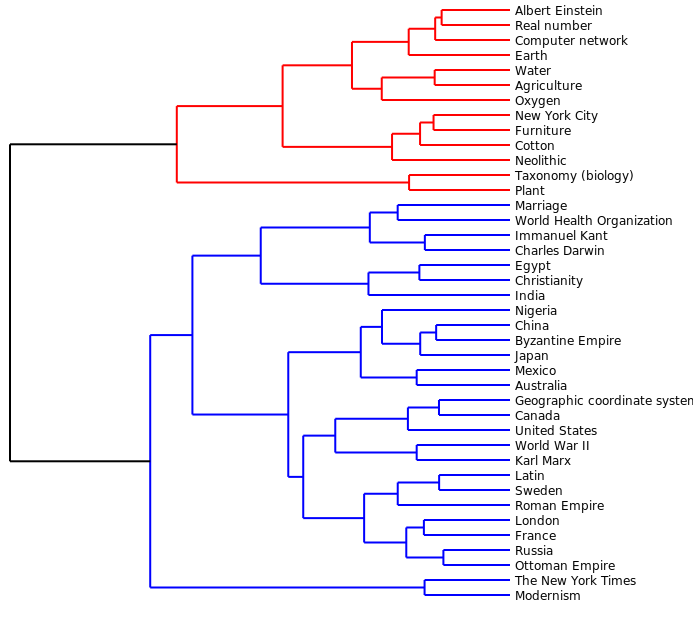

In [470]:
articles = []
for label in labels_unique:
    mask = labels == label
    scores = pagerank.fit_predict(adjacency, weights=mask)
    top_idx = np.argmax(scores[mask])
    top_article = np.nonzero(mask)[0][top_idx]
    articles.append(top_article)

image = visualize_dendrogram(
    dendrogram_aggregate,
    names=names[articles],
    rotate=True,
    width=500,
    height=600,
)
SVG(image)

We can see that clusters that merge early are more closely related, while those that merge later are more distinct. This visualization helps to understand both the diversity and the organization of knowledge in the dataset, highlighting the most influential articles within each thematic group.

## To do

* Complete the following function that returns the nested clusters from a target node in a dendrogram.
* Give the size and top-5 articles of each nested cluster from the article **Riverboat**.
* Do the same with another article of your choice.

In [471]:
def get_nested_clusters(dendrogram: np.ndarray, node: int): 
    '''Get the nested clusters of a node, following the path from the corresponding leaf to the root in the dendrogram.
    
    Parameters
    ----------
    dendrogram: 
        Dendrogram
    node:
        Target node
        
    Returns
    -------
    cluster_nested: list of list
        Nested clusters, as a partition of the set of nodes 
        (the k-th nested cluster is the concatenation of the first k lists). 
        
    Example
    -------
    >>> dendrogram = np.array([[0, 1, 1, 2], [2, 3, 1, 2], [4, 5, 1, 4]])
    >>> get_nested_clusters(dendrogram, 0)
    [[0], [1], [2, 3]]
    '''
    n = dendrogram.shape[0] + 1
    
    cluster = {i: [i] for i in range(n)}
    nested_clusters = [[node]]
    cluster_index = node
    
    for t in range(n - 1):
        i = int(dendrogram[t][0])
        j = int(dendrogram[t][1])
        if i == cluster_index:
            nested_clusters.append(cluster[j])
            cluster_index = n + t
        elif j == cluster_index:
            nested_clusters.append(cluster[i])
            cluster_index = n + t
        cluster[n + t] = cluster[i] + cluster[j]
    
    return nested_clusters

In [472]:
riverboat_index = np.where(names == 'Riverboat')[0][0]

nested_clusters = get_nested_clusters(dendrogram, riverboat_index)
pagerank = PageRank()

cluster = []
for k, cluster_add in enumerate(nested_clusters):
    cluster += cluster_add
    weights = {node: 1 for node in cluster}
    scores = pagerank.fit_predict(adjacency, weights)
    cluster_arr = np.array(cluster)
    top_idx = np.argsort(-scores[cluster_arr])[:5]
    top_names = [f"{names[cluster_arr[i]]} ({scores[cluster_arr[i]]:.3g})" for i in top_idx]
    print(f"Nested cluster {k}: size={len(cluster)}, top-5 articles: {', '.join(top_names)}")

Nested cluster 0: size=1, top-5 articles: Riverboat (0.151)
Nested cluster 1: size=2, top-5 articles: Tanker (ship) (0.079), Riverboat (0.0786)
Nested cluster 2: size=4, top-5 articles: Tanker (ship) (0.043), Riverboat (0.0428), Passenger ship (0.0424), Merchant ship (0.0397)
Nested cluster 3: size=5, top-5 articles: Tanker (ship) (0.0357), Riverboat (0.0355), Passenger ship (0.0352), Merchant ship (0.0319), Freight transport (0.0311)
Nested cluster 4: size=6, top-5 articles: Tanker (ship) (0.0304), Riverboat (0.0302), Passenger ship (0.03), Cargo ship (0.0278), Merchant ship (0.0271)
Nested cluster 5: size=7, top-5 articles: Fishing vessel (0.0273), Tanker (ship) (0.0264), Riverboat (0.0263), Passenger ship (0.026), Cargo ship (0.0242)
Nested cluster 6: size=8, top-5 articles: Fishing vessel (0.0244), Barge (0.024), Tanker (ship) (0.0236), Riverboat (0.0235), Passenger ship (0.0233)
Nested cluster 7: size=9, top-5 articles: Ferry (0.0219), Fishing vessel (0.0219), Barge (0.0215), Tank

In [476]:
paris_index = np.where(names == 'Paris')[0][0]

nested_clusters = get_nested_clusters(dendrogram, paris_index)
pagerank = PageRank()

cluster = []
for k, cluster_add in enumerate(nested_clusters):
    cluster += cluster_add
    weights = {node: 1 for node in cluster}
    scores = pagerank.fit_predict(adjacency, weights)
    cluster_arr = np.array(cluster)
    top_idx = np.argsort(-scores[cluster_arr])[:5]
    top_names = [f"{names[cluster_arr[i]]} ({scores[cluster_arr[i]]:.3g})" for i in top_idx]
    print(f"Nested cluster {k}: size={len(cluster)}, top-5 articles: {', '.join(top_names)}")

Nested cluster 0: size=1, top-5 articles: Paris (0.152)
Nested cluster 1: size=19, top-5 articles: Paris (0.0111), Victor Hugo (0.0106), Gustave Flaubert (0.0102), Alexandre Dumas (0.0101), Molière (0.01)
Nested cluster 2: size=35, top-5 articles: Paris (0.0076), French Revolution (0.00638), Palace of Versailles (0.00631), Victor Hugo (0.00614), Louvre (0.00598)
Nested cluster 3: size=36, top-5 articles: Paris (0.00742), France (0.00623), French Revolution (0.00623), Palace of Versailles (0.00615), Victor Hugo (0.00599)
Nested cluster 4: size=65, top-5 articles: Paris (0.00464), France (0.00461), French Revolution (0.0039), Palace of Versailles (0.00352), Victor Hugo (0.00338)
Nested cluster 5: size=234, top-5 articles: France (0.00279), Italy (0.00238), Holy Roman Empire (0.00237), French Revolution (0.00211), Middle Ages (0.00211)
Nested cluster 6: size=335, top-5 articles: France (0.00251), Italy (0.00209), United Kingdom (0.00203), Holy Roman Empire (0.00195), Middle Ages (0.0019)
